# Example of MCMC run

In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using BenchmarkTools

In [2]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BenchmarkTools
using DSP

In [3]:
# using Revise
using BAT 

# Load Data

In [4]:
function trunc_norm(m, sgm; alpha=2)
    return truncated(Normal(m, sgm), m - alpha*sgm, m + alpha*sgm)
end

trunc_norm (generic function with 1 method)

## 1.1 Low `p` Population: 

In [45]:
conv_mat = load("../data/experiment/dataset_2/m1/conv-matrix-upd-2.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
)

images = load("../data/experiment/dataset_2/m1/images-satur.jld2");
event_number = 343

# Small Charge: Ev_1_3 = 343, Ev_1_1 = 137, Ev_1_2 = 9

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);

## 1.2 High `p` Population: 

In [46]:
# conv_mat = load("../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

# conv_matrices = (
#     cam_1 = conv_mat["cam_1"],
#     cam_2 = conv_mat["cam_2"],
#     cam_3 = conv_mat["cam_3"],
#     cam_4 = conv_mat["cam_4"], 
# ) 

# images = load("../data/experiment/dataset_2/m2/images-satur.jld2"); # removed saturated pixels
# # images = load("../data/experiment/dataset_2/m2/images.jld2"); # included saturated pixels
# event_number = 2

# # Large Charge: Ev_2_2 = 2, Ev_2_1 = 311, Ev_2_3 = 440

# event = (
#     cam_1 = images["cam_1"][event_number,:,:],
#     cam_2 = images["cam_2"][event_number,:,:],
#     cam_3 = images["cam_3"][event_number,:,:],
#     cam_4 = images["cam_4"][event_number,:,:],
#     population = images["charge"][event_number,:][1],
# );


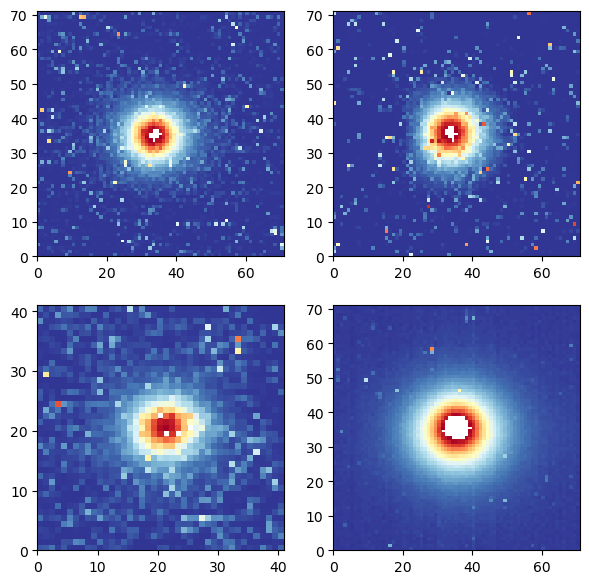

PyObject <matplotlib.collections.QuadMesh object at 0x7fe880781e50>

In [47]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

# Load Model

## Model 35: 

In [48]:
include("../src/model-35/likelihood.jl")
include("../src/model-35/utill_model.jl")
include("../src/utill.jl")

plot_projections (generic function with 1 method)

In [49]:
β1= 0.015
β2 = 0.0077
β3 = 0.0058 

prior = NamedTupleDist(
    tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.20), truncated(Normal(0.2, 0.04), 0.03, 0.20)],
    ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 7.0), truncated(Normal(4.0, 2.0), 2.0, 7.0)],
    waist = [Normal(2.9, 0.03)],
    algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
    cam4_ped = 4.0 .. 40.0,
    cam4_light_fluct = 1.0 .. 3.0,
    cam4_light_amp = 1.6 .. 9.9, 
    resx = [1.0, 1.0, 1.0], 
    resy = [1.0, 1.0, 1.0], 
    cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
    cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
    psx = [27.1, 21.6, 114.0], # 31, 32, 33
    psy = [30.5, 23.4, 125.0], # 34, 35, 36
    cam4_psx = 121.8, # 37
    cam4_psy = 120.0, # 38
    light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
    s_cam = [0.0, 1.478, 15.026, 23.1150],
); 

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.20), truncated(Normal(0.2, 0.04), 0.03, 0.20)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 7.0), truncated(Normal(4.0, 2.0), 2.0, 7.0)],
#     waist = [Normal(2.9, 0.03)],
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 1.0 .. 3.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#     resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#     cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
#     cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
#     psx = [27.1, 21.6, 114.0], # 31, 32, 33
#     psy = [30.5, 23.4, 125.0], # 34, 35, 36
#     cam4_psx = 121.8, # 37
#     cam4_psy = 120.0, # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ); 


## Model 38: 

In [50]:
# include("../src/model-38/likelihood.jl")
# include("../src/model-38/utill_model.jl")
# include("../src/utill.jl")

In [51]:
# β1= 0.015
# β2 = 0.0077
# β3 = 0.0058 

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
#     mixt_pow =  0.50 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 1.0 .. 3.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [trunc_norm(1, 0.5), trunc_norm(2, 1), trunc_norm(1, 0.5)], # 23, 24, 25, 
#     resy = [trunc_norm(1, 0.5), trunc_norm(2, 1), trunc_norm(1, 0.5)], # 26,27, 28, 
#     cam4_resx = trunc_norm(3, 1.5), # 29, 
#     cam4_resy = trunc_norm(3, 1.5), # 30
#     psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
#     psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
#     cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
#     cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ;

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.06, 0.20), truncated(Normal(0.2, 0.04), 0.06, 0.20)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
#     mixt_pow =  0.50 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 2.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [1, 1, 1], # 23, 24, 25, 
#     resy = [1, 1, 1], # 26,27, 28, 
#     cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
#     cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
#     psx = [27.1, 21.6, 114.0], # 31, 32, 33
#     psy = [30.5, 23.4, 125.0], # 34, 35, 36
#     cam4_psx = 121.8, # 37
#     cam4_psy = 120.0, # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ;

## Model 41: 

In [52]:
# include("../src/model-41/likelihood.jl")
# include("../src/model-41/utill_model.jl")
# include("../src/utill.jl")

In [53]:
# β1= 0.015
# β2 = 0.0077
# β3 = 0.0058 

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
#         tr_size_2 = [truncated(Normal(0.2, 0.04), 0.06, 0.19), truncated(Normal(0.2, 0.04), 0.06, 0.19)],
#         ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#         ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
#         mixt_pow =  0.50 .. 1.0 ,
#         waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
#         waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
#         algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#         algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#         cam4_ped = 4.0 .. 40.0,
#         cam4_light_fluct = 1.0 .. 3.0,
#         cam4_light_amp = 1.6 .. 9.9, 
#         resx = [1, 1, 1], # 23, 24, 25, 
#         resy = [1, 1, 1], # 26,27, 28, 
#         cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
#         cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
#         psx = [27.1, 21.6, 114.0], # 31, 32, 33
#         psy = [30.5, 23.4, 125.0], # 34, 35, 36
#         cam4_psx = 121.8, # 37
#         cam4_psy = 120.0, # 38
#         light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#         s_cam = [0.0, 1.478, 15.026, 23.1150],
#     );



# MCMC settings: 

In [54]:
"""
    Log-Likelihood of the beamline (4 cameras included)
"""
function log_lik_ndiff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_discrete,
    cv_1 = cv_mat.cam_1,
    cv_2 = cv_mat.cam_2,
    cv_3 = cv_mat.cam_3,
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        return LogDVal(ll)
    end
        
end

function log_lik_diff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_cont,
    cv_1 = exp.(cv_mat.cam_1),
    cv_2 = exp.(cv_mat.cam_2),
    cv_3 = exp.(cv_mat.cam_3),
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        
        return LogDVal(ll)
    end
    
end

# log_likelihood = log_lik_diff()

log_likelihood = log_lik_ndiff()

#109 (generic function with 1 method)

In [55]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCChainPoolInit(
    init_tries_per_chain = ClosedInterval(50,150),
    max_nsamples_init = 500,
    max_nsteps_init = 500,
    max_time_init = Inf
)

burnin = MCMCMultiCycleBurnin(
    max_nsamples_per_cycle = 6000,
    max_nsteps_per_cycle = 6000,
    max_time_per_cycle = Inf,
    max_ncycles = 130
)

nsamples = 1*10^5
nchains = 4

sampler = MetropolisHastings(tuning=tuning,)

algorithm = MCMCSampling(sampler=sampler, 
    nchains=nchains, 
    init=init, 
    burnin=burnin, 
    convergence=convergence
);

In [56]:
# log_likelihood(param_truth)
# @benchmark log_likelihood(param_truth)

In [57]:
@time samples_tot = bat_sample(
    posterior, nchains*nsamples, algorithm,
    max_neval = nchains*nsamples,
    max_time = Inf,
);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:63
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/chain_pool_init.jl:185
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 conver

761.719235 seconds (994.26 M allocations: 925.219 GiB, 7.43% gc time)


In [61]:
samples = samples_tot.result;

In [62]:
minimum(bat_eff_sample_size(unshaped.(samples)).result)

1308.5795642471235

In [63]:
size(flatview(unshaped.(samples.v)))

(21, 95308)

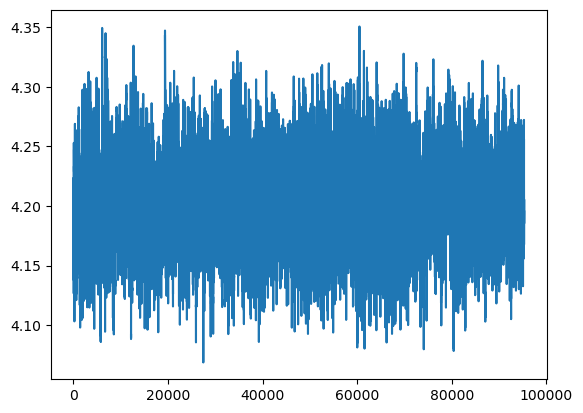

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe845434ee0>

In [64]:
plot(flatview(unshaped.(samples.v))[3,:])

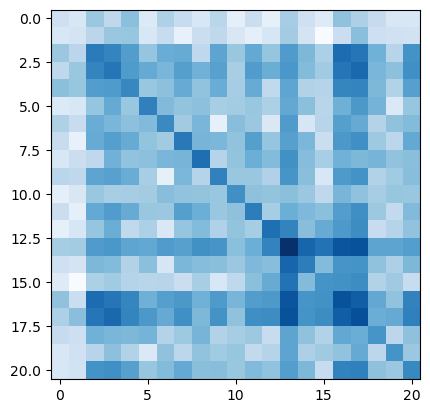

PyObject <matplotlib.image.AxesImage object at 0x7fe833c95fa0>

In [65]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

In [66]:
# BAT.bat_write("../data/sampling_results/Tmp-Mixture-Model-38-2/mm-38-hc-2-fixed-lf.hdf5", unshaped.(samples))

# BAT.bat_write("../data/sampling_results/Benchmark-8/samples-41.hdf5", unshaped.(samples))

In [67]:
#  27.1, 21.6, 114.0, 30.5, 23.4, 125.0, 121.8, 120.0

In [68]:
mode(samples)[1]

(tr_size = [0.09604779626235074, 0.11823386362884933], ang_spr = [4.172393897898746, 3.9453719855045426], waist = [3.054157857331001], algmx = [33.84154972785661, 34.40321894363583, 21.471452009703498, 35.78586279572362], algmy = [35.109200218873774, 35.73707919913098, 20.51037441235778, 34.89031296248827], cam4_ped = 20.42771948413635, cam4_light_fluct = 2.536051996684798, cam4_light_amp = 2.873235617150774, resx = [1.0, 1.0, 1.0], resy = [1.0, 1.0, 1.0], cam4_resx = 5.270111727917633, cam4_resy = 5.256253070967096, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [3.047175337977708, 4.650222470796678, 2.3400687216554488], s_cam = [0.0, 1.478, 15.026, 23.115])

In [69]:
bat_marginalmode(samples).result

ShapedAsNT((tr_size = [0.096075, 0.11852499999999999], ang_spr = [4.202999999999999, 3.949], waist = [3.0404999999999998], algmx = [33.841, 34.3905, 21.417, 35.785], algmy = [35.114999999999995, 35.7475, 20.499000000000002, 34.917], cam4_ped = 20.415, cam4_light_fluct = 2.541, cam4_light_amp = 2.8685, resx = [1.0, 1.0, 1.0], resy = [1.0, 1.0, 1.0], cam4_resx = 5.2325, cam4_resy = 5.202500000000001, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [3.0605, 4.6395, 2.3325], s_cam = [0.0, 1.478, 15.026, 23.115]))

In [70]:
mean(samples)[1]

(tr_size = [0.09590429497968059, 0.1187101352359366], ang_spr = [4.202482594981085, 3.9511914843222726], waist = [3.0411219474989295], algmx = [33.836089289390344, 34.38561142420696, 21.420760090661016, 35.784425701904006], algmy = [35.118694100686916, 35.748746563341285, 20.498367275885197, 34.92291346008544], cam4_ped = 20.428503645079385, cam4_light_fluct = 2.5434470150402824, cam4_light_amp = 2.8647983940358404, resx = [1.0, 1.0, 1.0], resy = [1.0, 1.0, 1.0], cam4_resx = 5.235728372032088, cam4_resy = 5.180839575354364, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [3.0564135503101904, 4.639045789486772, 2.326598839008557], s_cam = [0.0, 1.478, 15.026, 23.115])

In [71]:
std(samples)[1]

(tr_size = [0.000913431231479438, 0.0007190859469408856], ang_spr = [0.03450617295075016, 0.03932638260241405], waist = [0.025414329084138387], algmx = [0.029964540789877453, 0.023723994218035508, 0.03647580676219172, 0.05010124285969288], algmy = [0.029336285094195044, 0.01955715033386368, 0.032463831491879994, 0.047513774429486365], cam4_ped = 0.2823804014292974, cam4_light_fluct = 0.033140148188506066, cam4_light_amp = 0.017140380066870846, resx = 3-element Fill{Float64}: entries equal to 0.0, resy = 3-element Fill{Float64}: entries equal to 0.0, cam4_resx = 0.11043488852363348, cam4_resy = 0.11799909840005014, psx = 3-element Fill{Float64}: entries equal to 0.0, psy = 3-element Fill{Float64}: entries equal to 0.0, cam4_psx = 0.0, cam4_psy = 0.0, light_amp = [0.016469356276460477, 0.017625544945115187, 0.023699180301672815], s_cam = 4-element Fill{Float64}: entries equal to 0.0)

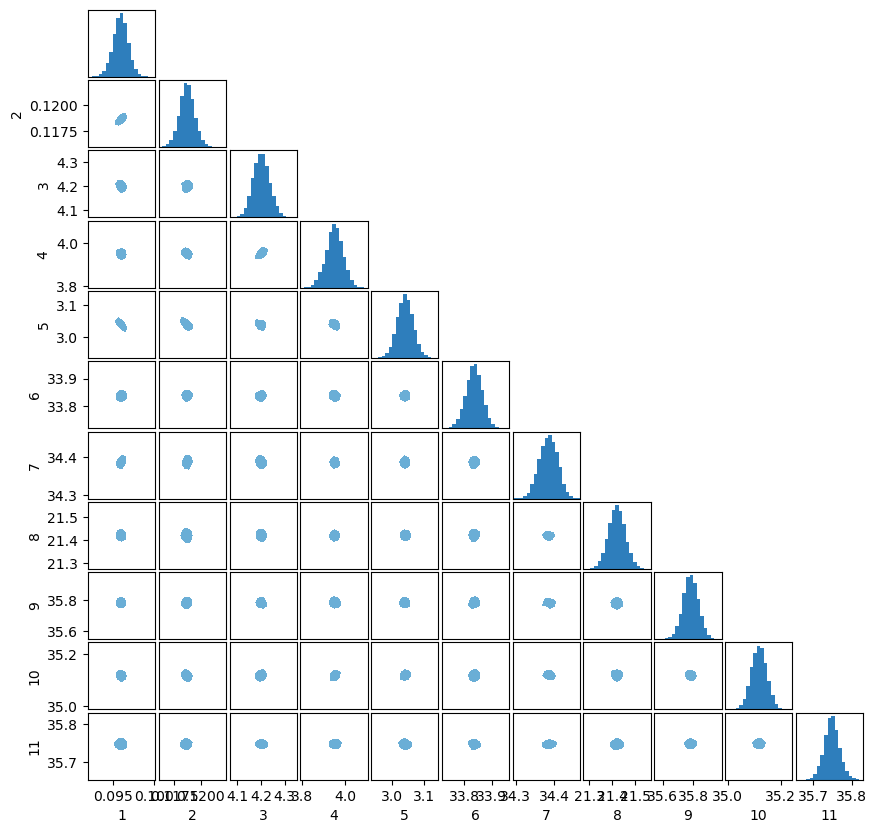

In [72]:
dims = [1,2,3,4,5,6,7,8,9,10,11]
# dims = [1,2,3,4,5,]
names = [1,2,3,4,5,6,7,8,9,10, 11]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

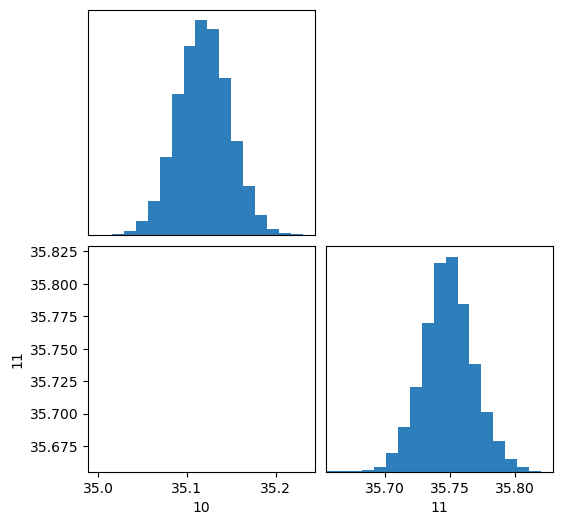

In [73]:
dims = [10,11,]
names = [10,11,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
levels = [0.1,  1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

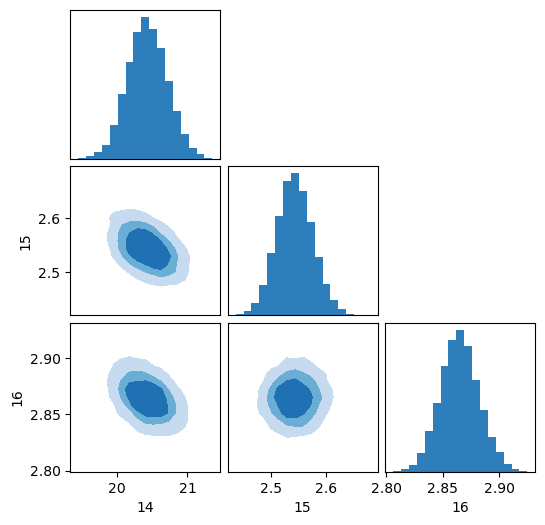

In [74]:
dims = [14,15,16,]
names = [14,15,16,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [75]:
# res

dims = [17,18,19,20,21,22,23,24]
names = [17,18,19,20,21, 22, 23, 24]
levels = [0.1, 0.5, 0.9, 0.95,  1,]
levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 21×95308 ElasticArrays.ElasticArray{Float64,2,1,Array{Float64,1}} at index [22, 1:95308]

In [76]:
#pix

dims = [25,26,27,28,29, 30, 31, 32]
names = [25,26,27,28,29, 30, 31, 32]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
levels = [0.1, 0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 21×95308 ElasticArrays.ElasticArray{Float64,2,1,Array{Float64,1}} at index [25, 1:95308]

In [77]:
dims = [33, 34, 35]
names = [33, 34, 35]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 21×95308 ElasticArrays.ElasticArray{Float64,2,1,Array{Float64,1}} at index [33, 1:95308]

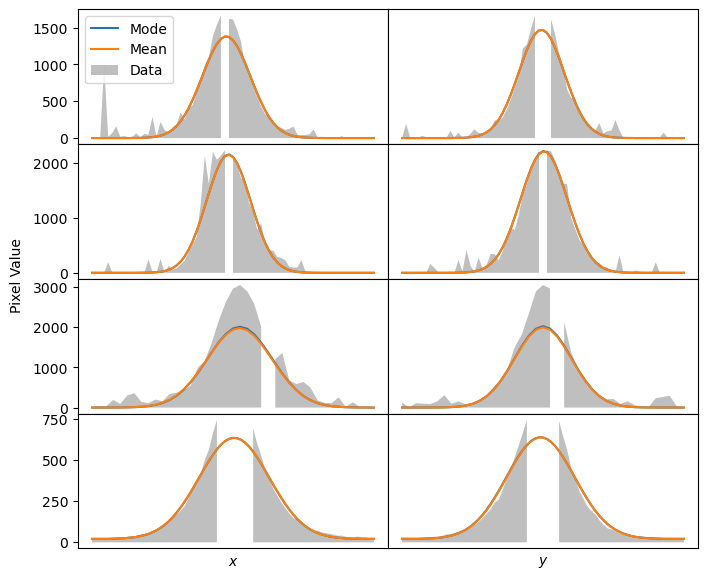

PyObject Text(0.04, 0.5, 'Pixel Value')

In [78]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

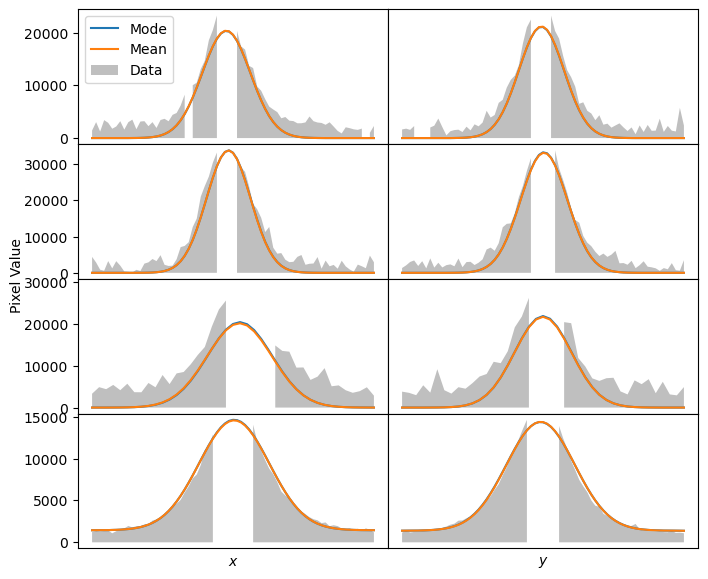

PyObject Text(0.04, 0.5, 'Pixel Value')

In [79]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

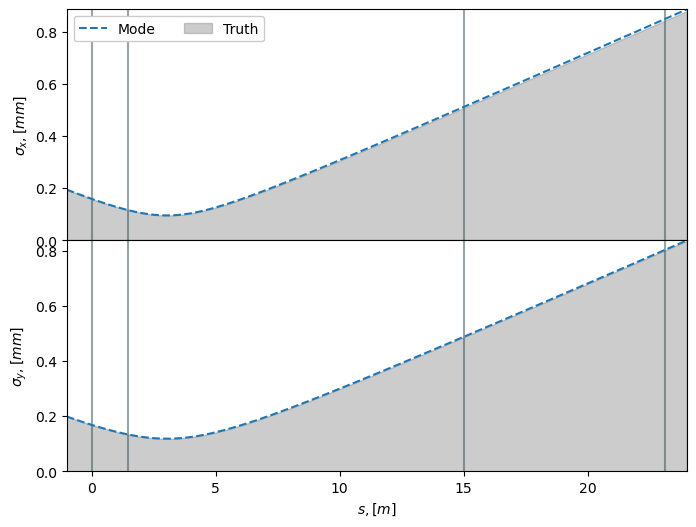

PyObject Text(0.5, 26.28125, '$s, [m]$')

In [80]:
params_array = [mode(samples)[1], mean(samples)[1]]
colors_array = ["gray", "C0", "C1"]
labels_array = ["Truth", "Mode", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

In [81]:
images = load("../data/experiment/dataset_2/m1/images.jld2")
event_ns = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);

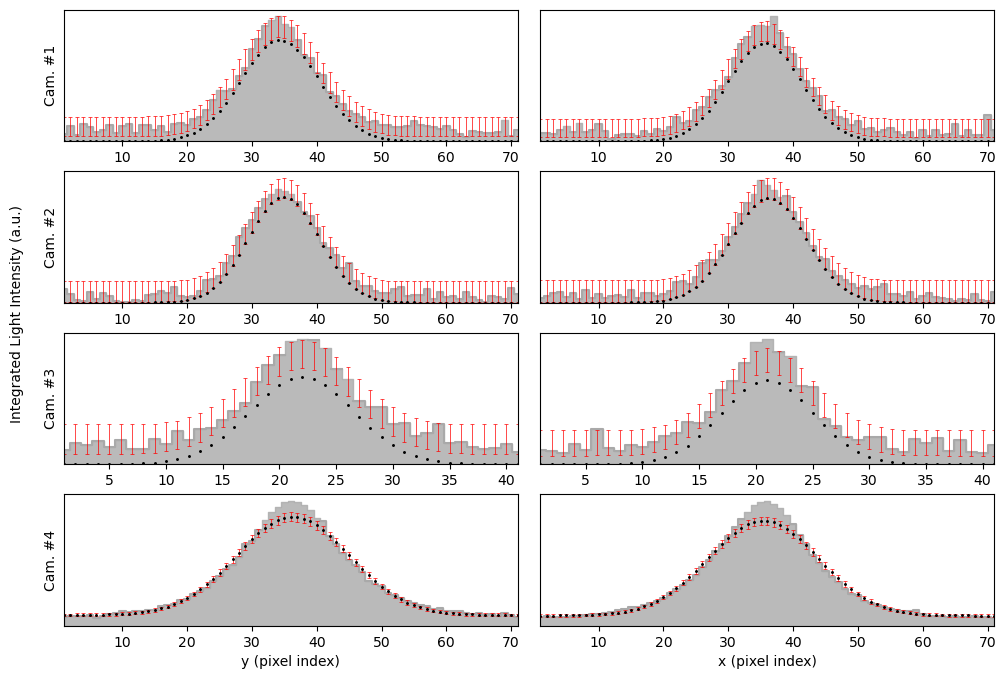

PyObject Text(0.08, 0.5, 'Integrated Light Intensity (a.u.)')

In [82]:
plot_projections(conv_matrices, event_ns, event, params_array[1], isnontr = true)

In [ ]:
# try model 38 with light fluctuations constant on the IS2
# fixe resolution in the IS2 amera